# Neural Networks Exercise 3

Amirkabir University of Technology

Dr. Safabakhsh

By Gholamreza Dar 

Spring 2022



## Imports

In [63]:
import datetime
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import RegularPolygon
from tqdm.notebook import trange
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# inits
sns.set_style('dark')
print(device_lib.list_local_devices())
np.random.seed(2)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11198061270846641058
xla_global_id: -1
]


## 3 - Loading the data

In [64]:
# Loading and parsing the data
X_train_df = pd.read_csv('X_train.txt', delim_whitespace=True, header=None)
X_test_df = pd.read_csv('X_test.txt', delim_whitespace=True, header=None)
y_train_df = pd.read_csv('y_train.txt', delim_whitespace=True, header=None)
y_test_df = pd.read_csv('y_test.txt', delim_whitespace=True, header=None)

In [65]:
# Shuffle the data
train_idx = np.random.permutation(X_train_df.index)
X_train_df = X_train_df.reindex(train_idx)
y_train_df = y_train_df.reindex(train_idx)

test_idx = np.random.permutation(X_test_df.index)
X_test_df = X_test_df.reindex(test_idx)
y_test_df = y_test_df.reindex(test_idx)

In [66]:
# Train, valid split
split = 0.8

X_train = X_train_df.iloc[ : int(len(X_train_df)*split),:].reset_index(drop=True)
X_valid = X_train_df.iloc[int(len(X_train_df)*split) : ,:].reset_index(drop=True)

y_train = y_train_df.iloc[ : int(len(y_train_df)*split)].reset_index(drop=True)
y_valid = y_train_df.iloc[int(len(y_train_df)*split) : ].reset_index(drop=True)

In [67]:
# Pandas to numpy
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().flatten()

X_valid = X_valid.to_numpy()
y_valid = y_valid.to_numpy().flatten()

X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy().flatten()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape} \n")

print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape} \n")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape} \n")


X_train shape: (5881, 561)
y_train shape: (5881,) 

X_valid shape: (1471, 561)
y_valid shape: (1471,) 

X_test shape: (2947, 561)
y_test shape: (2947,) 



In [68]:
# Cleanup
del X_train_df, X_test_df, y_train_df, y_test_df

## 4 - MLP

In [69]:
%load_ext tensorboard

### Create Model

In [70]:
# We make a function to create the model so that its easy to recreate the model
# with different hyperparameters.
def create_model():
    model = Sequential([
        Dense(256, activation='sigmoid', input_shape=(X_train.shape[1],)),
        Dense(256, activation='sigmoid'),
        Dense(256, activation='sigmoid'),
    ])
    return model

In [71]:
tf.keras.utils.plot_model(
    create_model(), to_file='model.png', show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=120,
    layer_range=None
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [72]:
# Create the model and compile it
model = create_model()
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               143872    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
Total params: 275,456
Trainable params: 275,456
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [73]:
# Tenserboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

In [74]:
# Train the model
# model.fit(x=X_train,
#         y=y_train,
#         epochs=20,
#         validation_data=(X_valid, Y_valid),
#         callbacks=[tensorboard_callback])

### Evaluate Model

In [75]:
# model.evaluate(X_test, y_test)

### Tensorboard

In [76]:
# %tensorboard --logdir logs/fit

## 5 - SOM

In [95]:
class SOM:
    def __init__(self, map_size, lr=0.1, R0=4):
        """
        Args:
            map_size : [map_w, map_h, f=561]
        """
        self.map = np.random.random(size=(map_size[0], map_size[1], map_size[2]))

        self.lr0 = lr
        self.lr = self.lr0

        self.R0 = R0
        self.R = self.R0

        self.Js = []
        self.dead_neurons_count_per_iter = []
        self.avg_distance_to_winners_per_iter = []
        self.dead_neurons = None

        self.visualize_color()

    def train(self, X, y, T=1000, error_threshold=10**-20, viz=False):
        # History lists
        self.Js = []
        self.dead_neurons_count_per_iter = []
        self.avg_distance_to_winners_per_iter = []

        for t in trange(T):
            dead_neurons = np.ones((self.map.shape[0], self.map.shape[1]))
            sum_distance_to_winners = 0
            prev_map = self.map.copy()
            # Shuffle X in every iteration
            shuffle_ind = np.random.randint(0, X.shape[0], X.shape[0])
            for i in range(len(X)):
                x = X[shuffle_ind[i], :]
                # Neuron with most compatibilty with x
                winner = self.find_winner(x)
                # Mark the winner neuron as a "not dead" neuron
                dead_neurons[winner[0], winner[1]] = 0
                # Sum up the distances between each x and its winner neuron
                sum_distance_to_winners += np.linalg.norm(x - self.map[winner[0], winner[1]])
                # Get all neurons in the neighborhood of winner
                NS = self.get_NS(winner)
                # Update weights of all neurons in the neighborhood of winner
                self.update_weights(x, NS, len(X)) 

            # Update learning rate and neighborhood radius (linear decay)
            self.lr = self.lr0 * (1 - t / T)
            # self.R = self.R0 * (1 - t / T)


            # Lists for visualization
            self.Js.append(np.linalg.norm(prev_map - self.map))
            self.dead_neurons_count_per_iter.append(dead_neurons.sum())
            self.avg_distance_to_winners_per_iter.append(sum_distance_to_winners / len(X)) # avg

            div = 1
            if T >= 50:
                div = 10
            if T >= 100:
                div = 50
            if T >= 500:
                div = 100

            if t%div == 0 or t == T-1:
                print(f"Iteration: {t}, Loss: {self.Js[-1]:.4f}, lr: {self.lr:.4f}, R: {self.R:.4f}")
            
                if viz:
                    self.visualize_color()
                    # self.visualize(X, y)
            
            if self.Js[-1] < error_threshold:
                print("MIN CHANGE")
                break

        return self.Js
    
    def find_winner(self, x):
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        dists = np.sum((self.map - rep_x) ** 2, axis=2)
        winner = np.unravel_index(np.argmin(dists, axis=None), shape=dists.shape)
        return winner

    def get_NS(self, winner):
        # NS: Neighborhood strength
        NS = np.zeros((self.map.shape[0], self.map.shape[1]))

        # winner i,j
        iw, jw = winner[0], winner[1]
        
        NS[iw, jw] = 1 # Winner

        # Circular neighborhood
        R = int(self.R)
        for ri in range(-R, R+1):
            for rj in range(-R, R+1):
                if 0 <= iw + ri < self.map.shape[0] and 0 <= jw + rj < self.map.shape[1]:
                    # NS[iw + ri, jw + rj] = 0 if np.sqrt(ri**2 + rj**2)>R else 1/(1+np.sqrt(ri**2 + rj**2))
                    NS[iw + ri, jw + rj] = 1/(1+np.sqrt(ri**2 + rj**2))
        return NS

    def update_weights(self, x, n_strength, X_len):
        # Note: n_strength is already W*H we just need to make it W*H*f
        NS = np.tile(n_strength, (self.map.shape[2], 1, 1)).transpose()

        # Difference between inputs and neurons
        # rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        # Delta = rep_x - self.map
        Delta = x - self.map

        # Update weights
        # self.map = self.map + (self.lr/X_len) * np.multiply(NS, Delta)
        self.map = self.map + (self.lr/X_len) * NS * Delta

    def visualize(self, X, y, classes=6, cmap='twilight'):
        self.scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1], classes+1)) # 6 classes + 1 dead
        for i in range(len(X)):
            x = X[i, :]
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            self.scores[iw, jw, y[i]] += 1
        
        top_class = np.argmax(self.scores, axis=2)
        plt.figure(figsize=(10, 10))
        plt.title("SOM Clustering Result")
        plt.imshow(top_class, cmap=cmap, vmin=0, vmax=classes+1) #gnuplot, twilight, Set1, inferno
        plt.show()
        
        return self.scores
    
    def visualize_color(self,):
        fig=plt.figure(figsize=(10,10))
        ax=fig.add_subplot(111,aspect="equal")
        ax.set_xlim((0,self.map.shape[0]+1))
        ax.set_ylim((0,self.map.shape[1]+1))
        ax.set_title(f"Self Organising map")
        ax.invert_yaxis()
        for x in range(1,self.map.shape[0]+1):
            for y in range(1,self.map.shape[1]+1):
                ax.add_patch(matplotlib.patches.Rectangle((x-0.5,y-0.5),1,1, facecolor=self.map[x-1,y-1,:3], edgecolor="black"))
        plt.show()
    
    def visualize_color_hex(self,):

        # Map coordinate
        rows = np.tile(np.arange(0,self.map.shape[0],1), (self.map.shape[1],1)).reshape(self.map.shape[0],self.map.shape[1],1)
        cols = np.tile(np.arange(0,self.map.shape[1],1), (self.map.shape[0],1)).T.reshape(self.map.shape[0],self.map.shape[1],1)
        coord = np.concatenate((rows, cols), axis=2).reshape(-1, 2)

        # Hexagons radius
        radius = 1/np.sqrt(3)

        # Horizontal cartesian coords
        hcoord = [c[0] if c[1]%2==0 else c[0]+0.5 for c in coord]

        # Vertical cartersian coords
        vcoord = [coord[i][1]-i//self.map.shape[1]*(1-(1/np.sqrt(3)+1/np.sqrt(3)/2)) for i in range(len(coord))]

        fig, ax = plt.subplots(1, figsize=(10, 10))
        fig.suptitle("SOM Clustering Result", y=0.86)
        ax.set_aspect('equal')
        ax.invert_yaxis()

        # Add some coloured hexagons
        for i, (x, y) in enumerate(zip(hcoord, vcoord)):
            color = self.map[i//self.map.shape[1], i%self.map.shape[1], :3]
            hex = RegularPolygon((x, y), numVertices=6, radius=radius,
                                orientation=np.radians(60), facecolor=color,
                                alpha=1.0, edgecolor='k', linewidth=0.3)
            ax.add_patch(hex)

        # Also add scatter points in hexagon centres
        ax.scatter(hcoord, vcoord, alpha=0.0)

        plt.show()
        
    
    def visualize_hex(self, X, y, classes=6, cmap='twilight'):
        self.scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1], classes+1)) # 6 classes + 1 dead
        for i in range(len(X)):
            x = X[i, :]
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            self.scores[iw, jw, y[i]] += 1
        
        top_class = np.argmax(self.scores, axis=2)

        # Map coordinate
        rows = np.tile(np.arange(0,self.map.shape[0],1), (self.map.shape[1],1)).reshape(self.map.shape[0],self.map.shape[1],1)
        cols = np.tile(np.arange(0,self.map.shape[1],1), (self.map.shape[0],1)).T.reshape(self.map.shape[0],self.map.shape[1],1)
        coord = np.concatenate((rows, cols), axis=2).reshape(-1, 2)

        # Hexagons radius
        radius = 1/np.sqrt(3)

        # Horizontal cartesian coords
        hcoord = [c[0] if c[1]%2==0 else c[0]+0.5 for c in coord]

        # Vertical cartersian coords
        vcoord = [coord[i][1]-i//self.map.shape[1]*(1-(1/np.sqrt(3)+1/np.sqrt(3)/2)) for i in range(len(coord))]

        fig, ax = plt.subplots(1, figsize=(10, 10))
        fig.suptitle("SOM Clustering Result", y=0.86)
        ax.set_aspect('equal')
        ax.invert_yaxis()

        current_cmap = matplotlib.cm.get_cmap(cmap)
        norm = matplotlib.colors.Normalize(vmin=0.0, vmax=classes+1)

        # Add some coloured hexagons
        for i, (x, y) in enumerate(zip(hcoord, vcoord)):
            color = current_cmap(norm(top_class[i//self.map.shape[1], i%self.map.shape[1]]))
            hex = RegularPolygon((x, y), numVertices=6, radius=radius,
                                orientation=np.radians(60), facecolor=color,
                                alpha=1.0, edgecolor='k', linewidth=0.3)
            ax.add_patch(hex)

        # Also add scatter points in hexagon centres
        ax.scatter(hcoord, vcoord, alpha=0.0)

        plt.show()
        return self.scores

    def plot_loss(self):
        plt.figure(figsize=(10, 10))
        plt.plot(self.Js)
        plt.title("Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
    
    def plot_mean_distance_to_winners(self):
        plt.figure(figsize=(10, 10))
        plt.plot(self.avg_distance_to_winners_per_iter)
        plt.title("Mean Distance to Winners")
        plt.xlabel("Iteration")
        plt.ylabel("Distance")
        plt.show()
    
    def plot_dead_neurons_count(self):
        plt.figure(figsize=(10, 10))
        plt.plot(self.dead_neurons_count_per_iter)
        plt.title("Dead Neurons Count")
        plt.xlabel("Iteration")
        plt.ylabel("Count")
        plt.show()

    def plot_win_count(self):
        win_count = np.sum(self.scores, axis=2)

        fig, ax = plt.subplots(figsize=(10,10))
        fig.suptitle("Win Count", y=0.95)
        ax.matshow(win_count, cmap='magma')

        for (i, j), z in np.ndenumerate(win_count):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='1.0', alpha=0.3))

        plt.show()
    
    def plot_U_matrix(self, R):
        # Calculate U matrix
        U = np.zeros(shape=(self.map.shape[0], self.map.shape[1]))
        for i in range(self.map.shape[0]):
            for j in range(self.map.shape[1]):

                # Circular neighborhood
                counter = 0
                R = int(R)
                for ri in range(-R, R):
                    for rj in range(-R, R):
                        if 0 <= i + ri < self.map.shape[0] and 0 <= j + rj < self.map.shape[1]:
                            U[i, j] += 0 if np.sqrt(ri**2 + rj**2)>R else np.linalg.norm(self.map[i, j] - self.map[i + ri, j + rj])
                            counter += 0 if np.sqrt(ri**2 + rj**2)>R else 1
        
                U[i, j] /= counter
        
        # Plotting U matrix
        fig, ax = plt.subplots(figsize=(10,10))
        fig.suptitle("U Matrix", y=0.95)
        ax.matshow(U, cmap='gray_r')

        for (i, j), z in np.ndenumerate(U):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='1.0', alpha=0.7))

        plt.show()

        return U
    
    def plot_U_matrix_hex(self, R):
        # Calculating U matrix
        U = np.zeros(shape=(self.map.shape[0], self.map.shape[1]))
        for i in range(self.map.shape[0]):
            for j in range(self.map.shape[1]):

                # Circular neighborhood
                counter = 0
                R = int(R)
                for ri in range(-R, R):
                    for rj in range(-R, R):
                        if 0 <= i + ri < self.map.shape[0] and 0 <= j + rj < self.map.shape[1]:
                            U[i, j] += 0 if np.sqrt(ri**2 + rj**2)>R else np.linalg.norm(self.map[i, j] - self.map[i + ri, j + rj])
                            counter += 0 if np.sqrt(ri**2 + rj**2)>R else 1
        
                U[i, j] /= counter
        
        # Plotting U matrix

        # Map coordinate
        rows = np.tile(np.arange(0,self.map.shape[0],1), (self.map.shape[1],1)).reshape(self.map.shape[0],self.map.shape[1],1)
        cols = np.tile(np.arange(0,self.map.shape[1],1), (self.map.shape[0],1)).T.reshape(self.map.shape[0],self.map.shape[1],1)
        coord = np.concatenate((rows, cols), axis=2).reshape(-1, 2)

        # Hexagons radius
        radius = 1/np.sqrt(3)

        # Horizontal cartesian coords
        hcoord = [c[0] if c[1]%2==0 else c[0]+0.5 for c in coord]

        # Vertical cartersian coords
        vcoord = [coord[i][1]-i//self.map.shape[1]*(1-(1/np.sqrt(3)+1/np.sqrt(3)/2)) for i in range(len(coord))]

        fig, ax = plt.subplots(1, figsize=(10, 10))
        fig.suptitle("U matrix", y=0.86)
        ax.set_aspect('equal')
        ax.invert_yaxis()

        current_cmap = matplotlib.cm.get_cmap("gray_r")
        norm = matplotlib.colors.Normalize(vmin=U.min(), vmax=U.max())

        # Add some coloured hexagons
        for i, (x, y) in enumerate(zip(hcoord, vcoord)):
            color = current_cmap(norm(U[i//self.map.shape[1], i%self.map.shape[1]]))
            hex = RegularPolygon((x, y), numVertices=6, radius=radius,
                                orientation=np.radians(60), facecolor=color,
                                alpha=1.0, edgecolor='k', linewidth=0.3)
            ax.add_patch(hex)
            ax.text(x, y, '{:0.1f}'.format(U[i//self.map.shape[1], i%self.map.shape[1]]), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='1.0', alpha=0.7))

        # Also add scatter points in hexagon centres
        ax.scatter(hcoord, vcoord, alpha=0.0)

        plt.show()
        return U

    def extract_features(self, x):
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        dists = np.sum((self.map - rep_x) ** 2, axis=2)
        return 1/(1+dists)
    
    def transform(self, X):
        new_X = np.ones((X.shape[0], self.map.shape[0]*self.map.shape[1]))
        for i, x in enumerate(X):
            new_X[i] = self.extract_features(x).flatten()
        return new_X

    def load_trained_model(self, model):
        self.map = model.map.copy()
        self.Js = model.Js.copy()
        self.dead_neurons_count_per_iter = model.dead_neurons_count_per_iter.copy()
        self.avg_distance_to_winners_per_iter = model.avg_distance_to_winners_per_iter.copy()
        self.dead_neurons = model.dead_neurons.copy()

In [78]:
def plot_classes_map(cmap='twilight'):
    current_cmap = matplotlib.cm.get_cmap(cmap)
    class_names = ["DEAD", "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
    fig, axs = plt.subplots(1,7, figsize=(15,3), constrained_layout=True)
    for i, ax in enumerate(axs):
        norm = matplotlib.colors.Normalize(vmin=0.0, vmax=7.0)
        color = current_cmap(norm(i))
        ax.set_axis_off()
        ax.set_title(f"{i} - {class_names[i].lower()}")
        ax.imshow(np.ones((200,400,4))*color)
    plt.show()

### Training

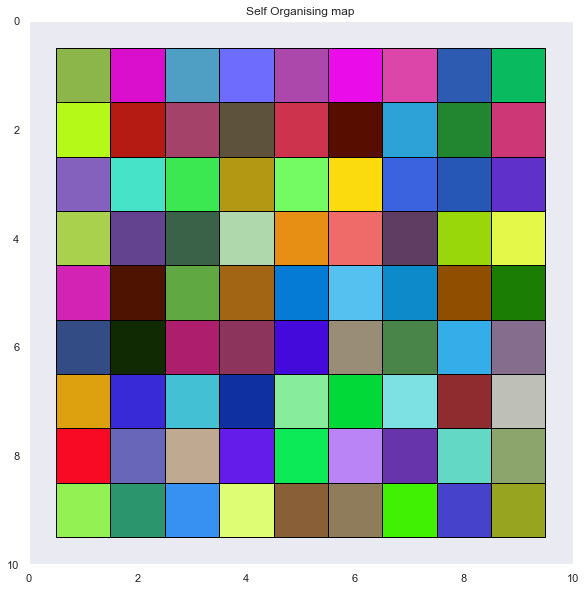

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0, Loss: 23.9414, lr: 0.8000, R: 4.0000
Iteration: 100, Loss: 0.8572, lr: 0.6400, R: 3.2000
Iteration: 200, Loss: 0.1835, lr: 0.4800, R: 2.4000
Iteration: 300, Loss: 0.0753, lr: 0.3200, R: 1.6000
Iteration: 400, Loss: 0.0219, lr: 0.1600, R: 0.8000
Iteration: 499, Loss: 0.0005, lr: 0.0016, R: 0.0080


In [79]:
# %%prun
saved = False

np.random.seed(3)
som_net = None
max_iter = 500
lr = 0.8

if saved:
    model_path = "./models/som_net_20220423-120132_3000 iterations_1.0 lr.pkl"
    som_net = pickle.load(open(model_path, "rb"))
    print("Model loaded without training:", model_path)
else:
    som_net = SOM(map_size=(9,9,X_valid.shape[1]), lr=lr)
    scores = som_net.train(X_valid, y_valid, T=max_iter, viz=False)
    pickle.dump(som_net, open(f"./models/som_net_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}_{max_iter} iterations_{lr} lr.pkl", "wb"))



### Visualization

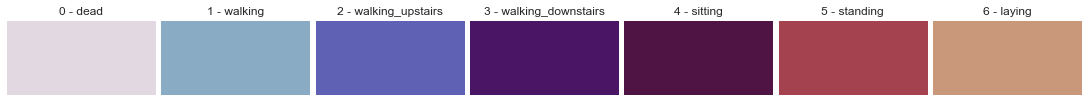

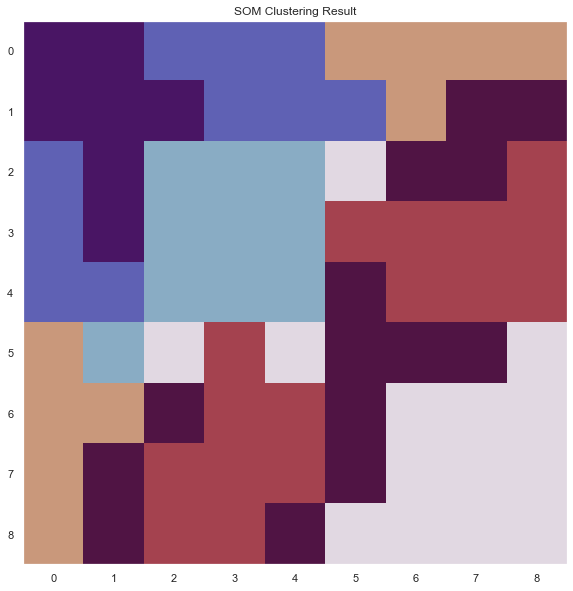

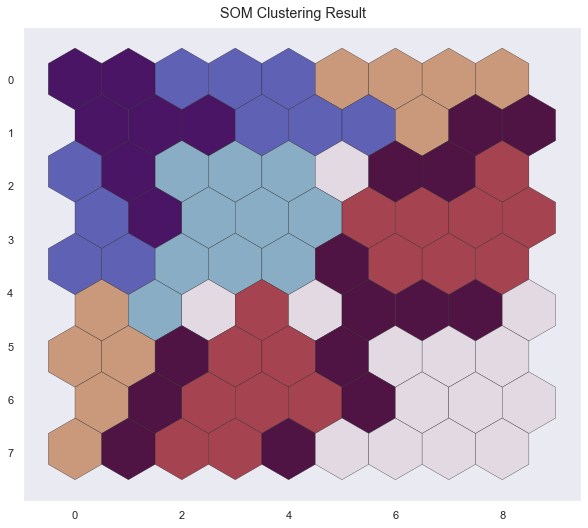

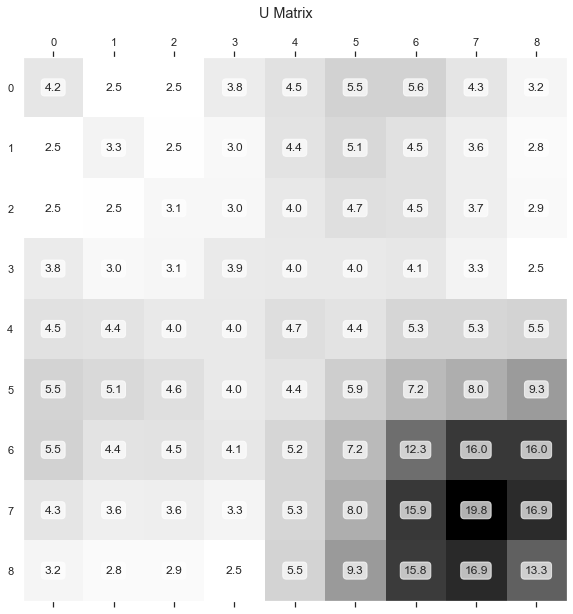

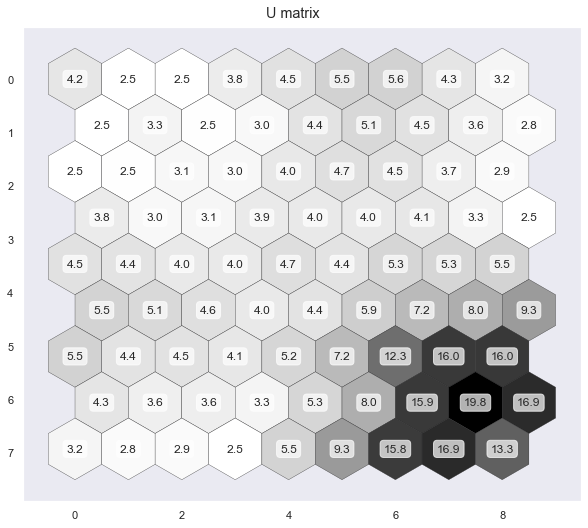

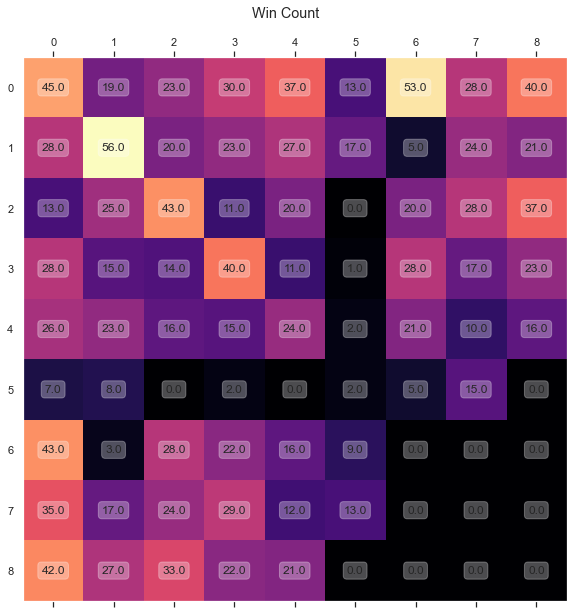

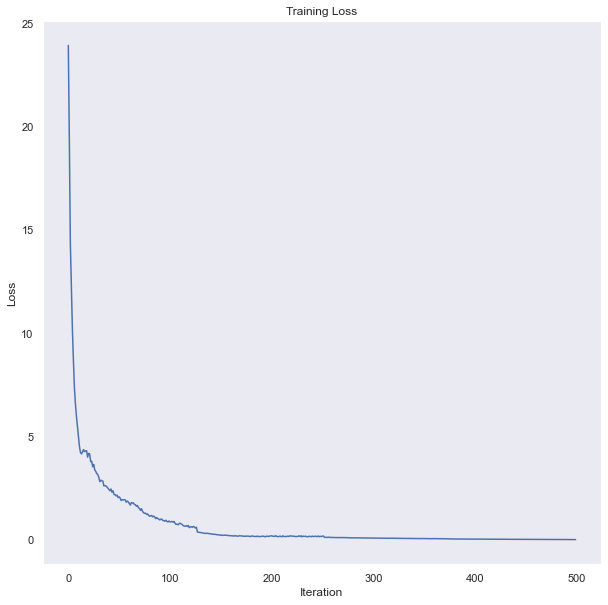

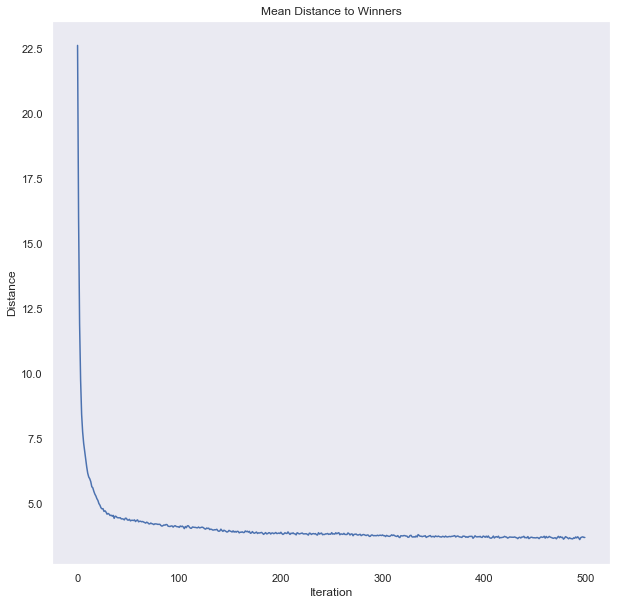

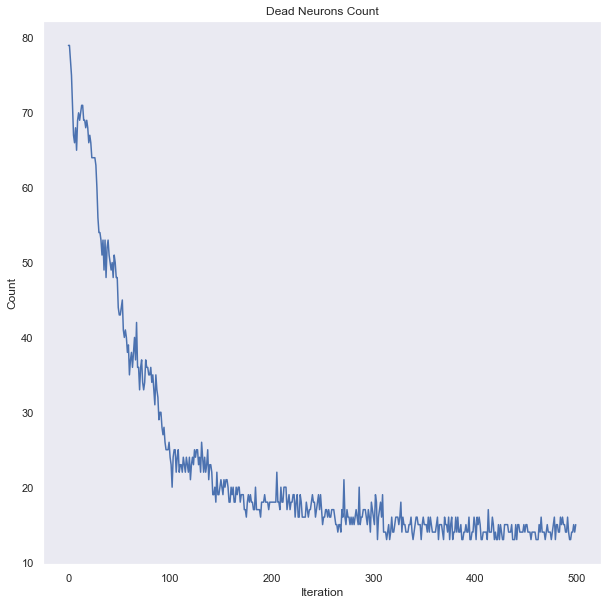

In [80]:
# Visualize
plot_classes_map(cmap='twilight')
scores = som_net.visualize(X_valid, y_valid, cmap='twilight')
som_net.visualize_hex(X_valid, y_valid, cmap='twilight')
som_net.plot_U_matrix(R=3)
som_net.plot_U_matrix_hex(R=3)
som_net.plot_win_count()
som_net.plot_loss()
som_net.plot_mean_distance_to_winners()
som_net.plot_dead_neurons_count()

### Feature Extraction

2


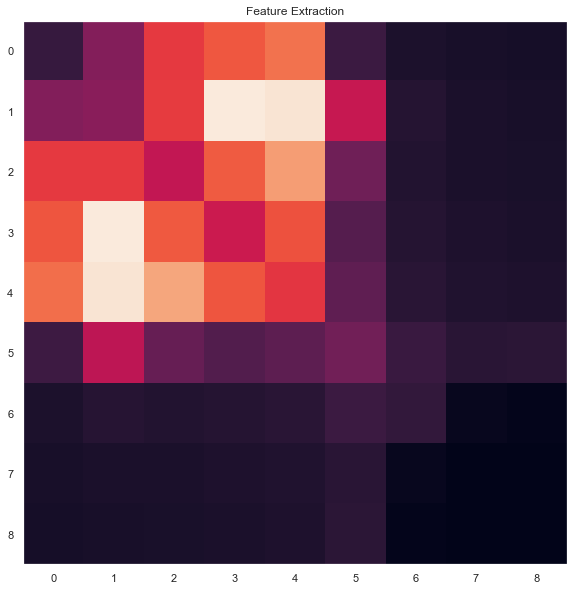

In [81]:
# Feature Extraction
i = 0
x = X_valid[i, :]
features = som_net.extract_features(x)
print(y_valid[i])
plt.figure(figsize=(10,10))
plt.imshow(features)
plt.title("Feature Extraction")
plt.show()
# predict the class using max cells color in colormap

### Plot U-matrix with different Rs

In [ ]:
# for i in [1,2,3,4,5,6,7,8,9,10]:
#     print(i)
#     som_net.plot_U_matrix(R=i)


## 6 - MLP with SOM extracted features

In [ ]:
# Transform
X_train_transformed = som_net.transform(X_train)
X_valid_transformed = som_net.transform(X_valid)
X_test_transformed = som_net.transform(X_test)

In [ ]:
# We make a function to create the model so that its easy to recreate the model
# with different hyperparameters.
def create_model2():
    model = Sequential([
        Dense(256, activation='sigmoid', input_shape=(X_train_transformed.shape[1],)),
        Dense(256, activation='sigmoid'),
        Dense(256, activation='sigmoid'),
    ])
    return model

tf.keras.utils.plot_model(
    create_model2(), to_file='model2.png', show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=120,
    layer_range=None
)

# Create the model and compile it
model2 = create_model2()
model2.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
model2.summary()

# Tenserboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)


In [ ]:
# Train the model

# model2.fit(x=X_train_transformed,
#         y=y_train,
#         epochs=20,
#         validation_data=(X_valid_transformed, Y_valid),
#         callbacks=[tensorboard_callback])

In [ ]:
# Evaluate

# model2.evaluate(X_test_transformed, y_test)

In [ ]:
# %tensorboard --logdir logs/fit

# ......................................................................................


## Test

In [ ]:
# # Fixing random state for reproducibility
# np.random.seed(19680801)

# n = 100000
# x = np.random.standard_normal(n)
# y =  np.random.standard_normal(n)
# xmin = x.min()
# xmax = x.max()
# ymin = y.min()
# ymax = y.max()

# fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(7, 3), dpi=120)
# fig.subplots_adjust(hspace=0.9, left=0.2, right=0.93)
# ax = axs[0]
# hb = ax.hexbin(x, y, gridsize=9, cmap='inferno')
# ax.axis([xmin, xmax, ymin, ymax])
# ax.set_title("Hexagon binning")
# cb = fig.colorbar(hb, ax=ax)
# cb.set_label('counts')

# ax = axs[1]
# hb = ax.hexbin(x, y, gridsize=9, bins='log', cmap='inferno')
# ax.axis([xmin, xmax, ymin, ymax])
# ax.set_title("With a log color scale")
# cb = fig.colorbar(hb, ax=ax)
# cb.set_label('log10(N)')

# plt.show()

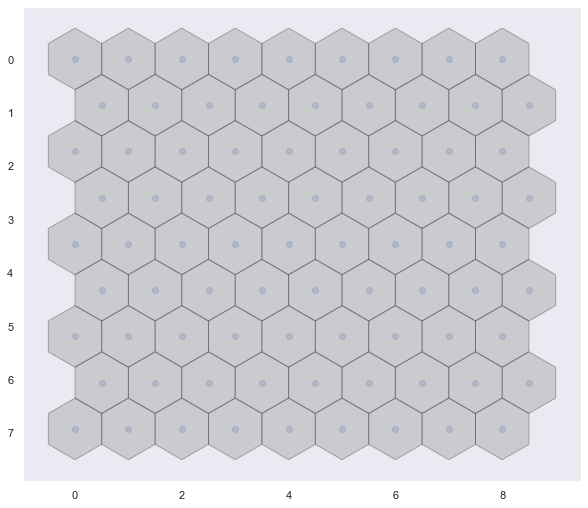

In [ ]:
# from matplotlib.patches import RegularPolygon


def draw_board(board, colors):

    coord = board

    radius = 1/np.sqrt(3)
    # Horizontal cartesian coords
    hcoord = [c[0] if c[1]%2==0 else c[0]+0.5  for c in coord]

    # Vertical cartersian coords
    # vcoord = [c[1] if c[1]!=0 else c[1]-(1-(1/np.sqrt(3)+1/np.sqrt(3)/2)) for c in coord]
    vcoord = [coord[i][1]-i//9*(1-(1/np.sqrt(3)+1/np.sqrt(3)/2)) for i in range(len(coord))]
    # vcoord = [coord[i][1] for i in range(len(coord))]


    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Add some coloured hexagons
    for x, y, c in zip(hcoord, vcoord, colors):
        color = c[0]
        hex = RegularPolygon((x, y), numVertices=6, radius=radius,
                            orientation=np.radians(60), facecolor="gray",
                            alpha=0.3, edgecolor='k')
        ax.add_patch(hex)
        # Also add a text label

    # Also add scatter points in hexagon centres
    ax.scatter(hcoord, vcoord, alpha=0.2)

    plt.show()


# # coord = np.array([
# #     [-1, 0],
# #     [ 0, 0], 
# #     [ 1, 0], 
# #     [-1, 1], 
# #     [ 0, 1], 
# #     [ 1, 1]])
# # colors = [["Green"],["Blue"],["red"],["orange"],["black"],["white"],["yellow"]]

rows = np.tile(np.arange(0,9,1), (9,1)).reshape(9,9,1)
cols = np.tile(np.arange(0,9,1), (9,1)).T.reshape(9,9,1)
coords = np.concatenate((rows, cols), axis=2).reshape(-1, 2)

colors = ["gray" for i in range(len(coords))]
# coords
draw_board(coords, colors)


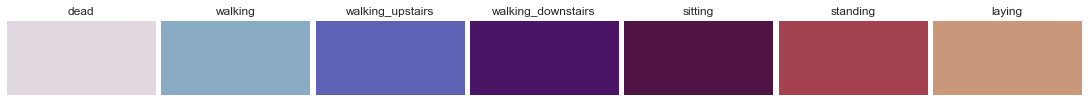

In [ ]:
#Colormap test
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def plot_classes_map(cmap='twilight'):
    current_cmap = matplotlib.cm.get_cmap(cmap)
    class_names = ["DEAD", "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
    fig, axs = plt.subplots(1,7, figsize=(15,3), constrained_layout=True)
    for i, ax in enumerate(axs):
        norm = matplotlib.colors.Normalize(vmin=0.0, vmax=7.0)
        color = current_cmap(norm(i))
        ax.set_axis_off()
        ax.set_title(class_names[i].lower())
        ax.imshow(np.ones((200,400,4))*color)
    plt.show()

plot_classes_map()

In [ ]:
a = []
for i in range(10):
    a.append(i)
a
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [39]:
np.random.seed(2)
np.random.random((3,3))


array([[0.4359949 , 0.02592623, 0.54966248],
       [0.43532239, 0.4203678 , 0.33033482],
       [0.20464863, 0.61927097, 0.29965467]])

In [35]:
np.random.random((3,3))

array([[0.26682728, 0.62113383, 0.52914209],
       [0.13457995, 0.51357812, 0.18443987],
       [0.78533515, 0.85397529, 0.49423684]])

In [36]:
np.random.random((3,3))

array([[0.84656149, 0.07964548, 0.50524609],
       [0.0652865 , 0.42812233, 0.09653092],
       [0.12715997, 0.59674531, 0.226012  ]])

### IRIS

In [25]:
from sklearn.datasets import load_iris
data = load_iris()
XX = data["data"]
YY = data["target"]+1
print(XX.shape)
print(YY.shape)

(150, 4)
(150,)


In [36]:
som_net_iris = SOM(map_size=(9,9,XX.shape[1]), lr=0.5)
scores_iris = som_net_iris.train(XX, YY, T=300, viz=False)

  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 0, Loss: 5.9564, lr: 0.5000, R: 4.0000
Iteration: 50, Loss: 0.3127, lr: 0.4167, R: 3.3333
Iteration: 100, Loss: 0.1226, lr: 0.3333, R: 2.6667
Iteration: 150, Loss: 0.0573, lr: 0.2500, R: 2.0000
Iteration: 200, Loss: 0.0165, lr: 0.1667, R: 1.3333
Iteration: 250, Loss: 0.0043, lr: 0.0833, R: 0.6667
Iteration: 299, Loss: 0.0002, lr: 0.0017, R: 0.0133


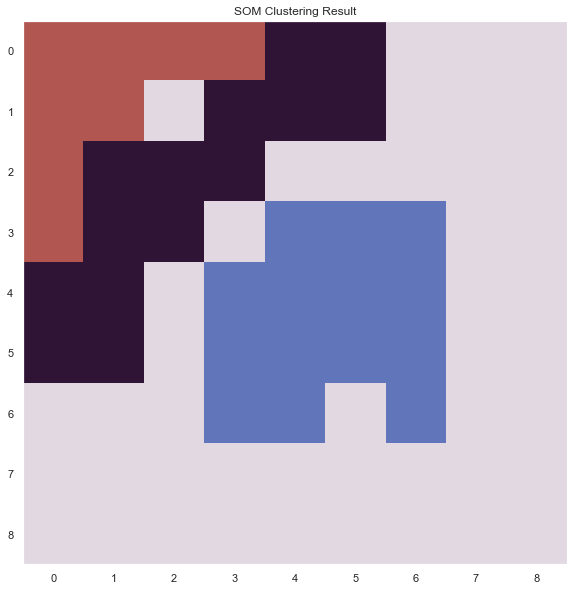

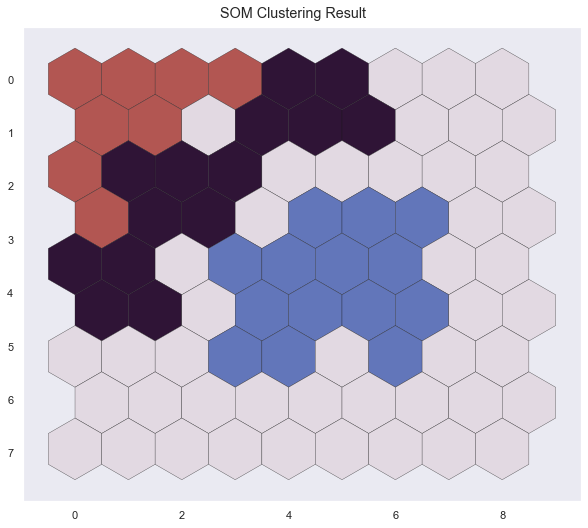

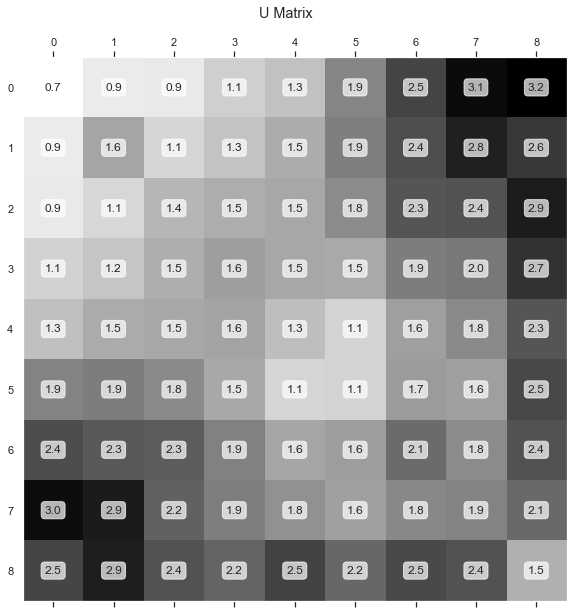

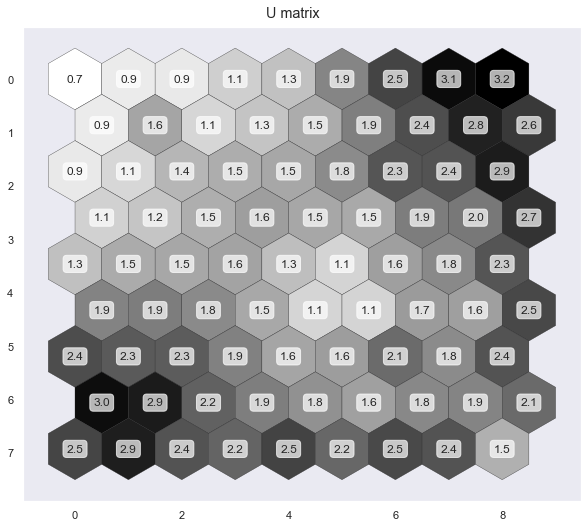

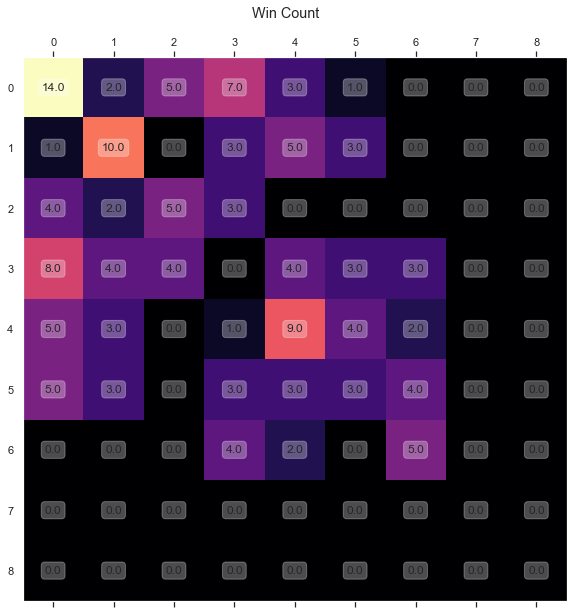

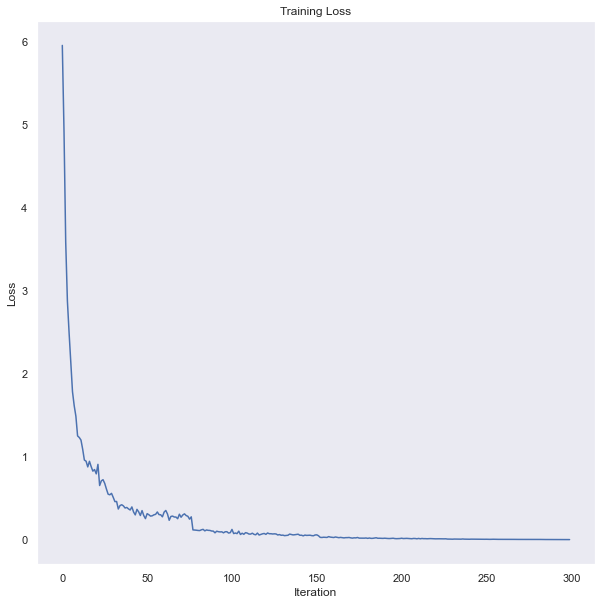

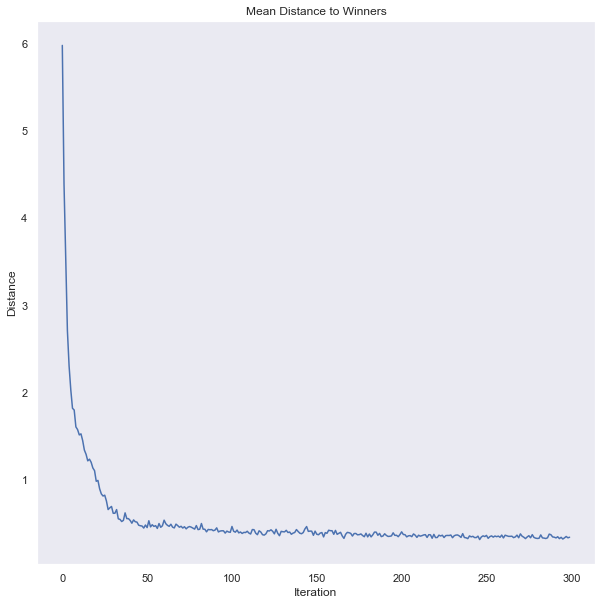

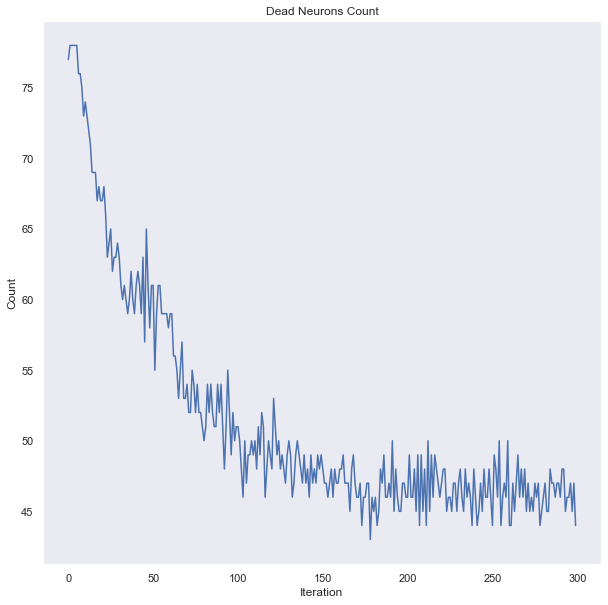

In [37]:
# plot_classes_map(cmap='twilight')
scores = som_net_iris.visualize(XX, YY, classes=3, cmap='twilight')
som_net_iris.visualize_hex(XX, YY, classes=3, cmap='twilight')
som_net_iris.plot_U_matrix(R=3)
som_net_iris.plot_U_matrix_hex(R=3)
som_net_iris.plot_win_count()
som_net_iris.plot_loss()
som_net_iris.plot_mean_distance_to_winners()
som_net_iris.plot_dead_neurons_count()

### Color

In [96]:
XXX = np.random.randint(0,256,(200,3))/255
YYY = np.ones(200)
print(XXX.shape)
print(YYY.shape)

(200, 3)
(200,)


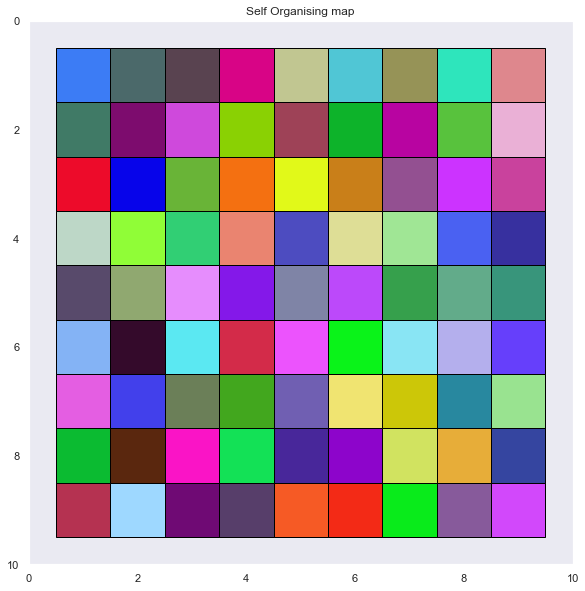

  0%|          | 0/400 [00:00<?, ?it/s]

Iteration: 0, Loss: 0.8313, lr: 1.5000, R: 3.0000
Iteration: 50, Loss: 0.0746, lr: 1.3125, R: 3.0000
Iteration: 100, Loss: 0.0575, lr: 1.1250, R: 3.0000
Iteration: 150, Loss: 0.0681, lr: 0.9375, R: 3.0000
Iteration: 200, Loss: 0.0410, lr: 0.7500, R: 3.0000
Iteration: 250, Loss: 0.0207, lr: 0.5625, R: 3.0000
Iteration: 300, Loss: 0.0164, lr: 0.3750, R: 3.0000
Iteration: 350, Loss: 0.0102, lr: 0.1875, R: 3.0000
Iteration: 399, Loss: 0.0004, lr: 0.0037, R: 3.0000


In [97]:
som_net_color = SOM(map_size=(9,9,XXX.shape[1]), lr=1.5, R0=3)
scores_color = som_net_color.train(XXX, YYY, T=400, viz=False)

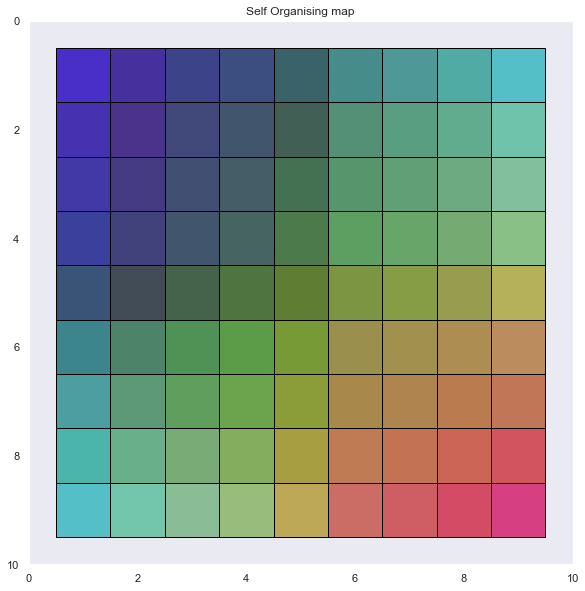

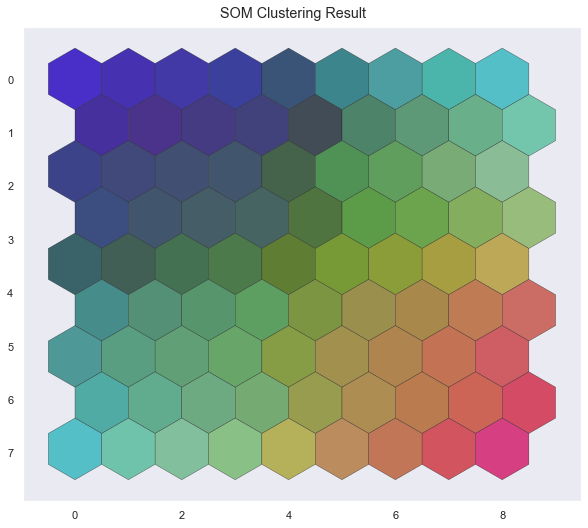

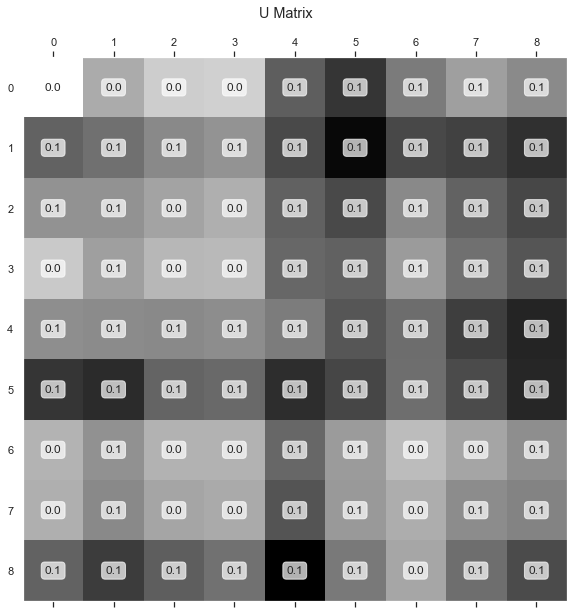

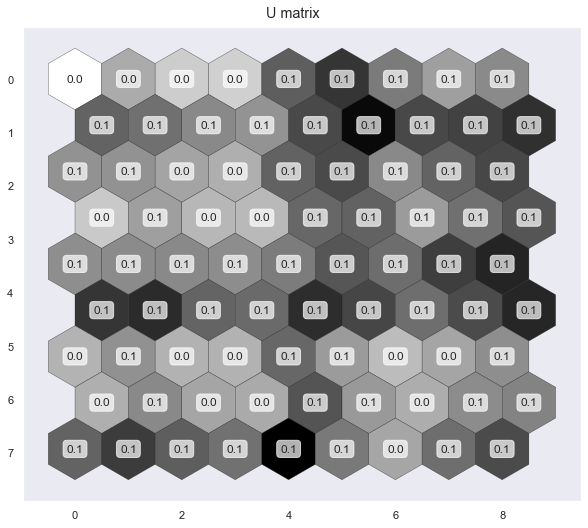

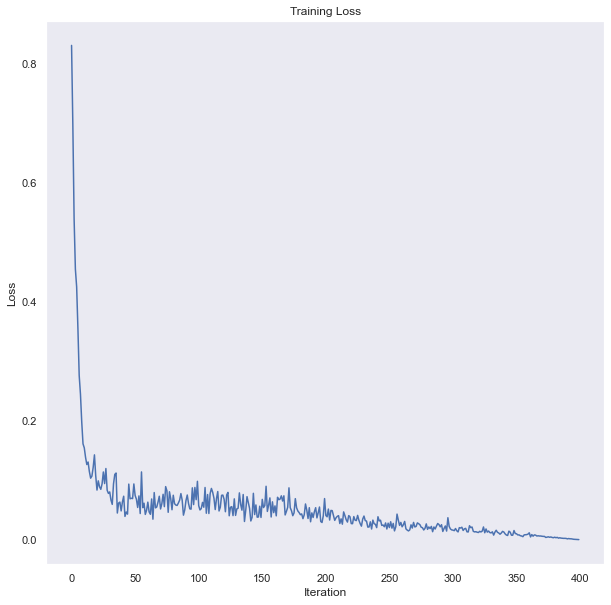

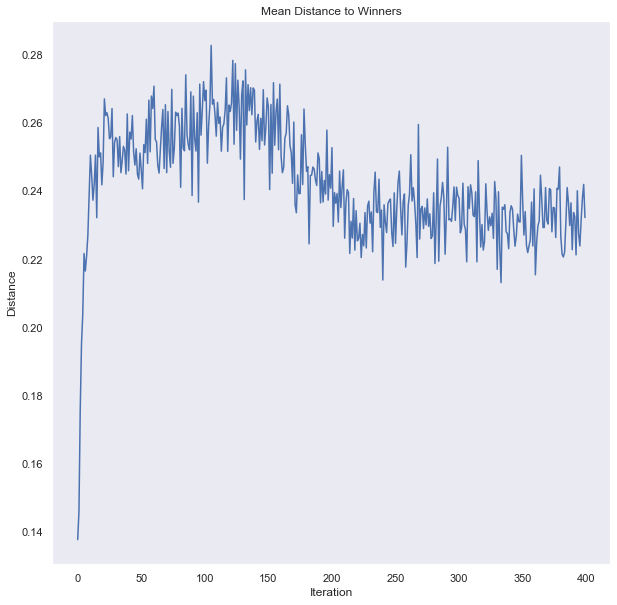

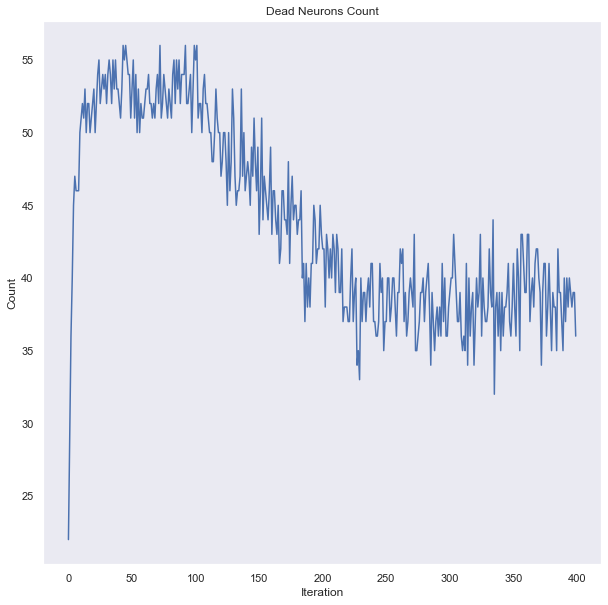

In [98]:
# plot_classes_map(cmap='twilight')
scores = som_net_color.visualize_color()
som_net_color.visualize_color_hex()
som_net_color.plot_U_matrix(R=1)
som_net_color.plot_U_matrix_hex(R=1)
# som_net_color.plot_win_count()
som_net_color.plot_loss()
som_net_color.plot_mean_distance_to_winners()
som_net_color.plot_dead_neurons_count()

### Congress

In [27]:
def load_dataset(path):
    df = pd.read_csv(path, delimiter=",")
    dataset = df.to_numpy()
    X = (dataset[:, 1:]+1)/2
    y = dataset[:, 0]

    return X, y

In [28]:
X_congress, y_congress = load_dataset("TA/congress.csv")

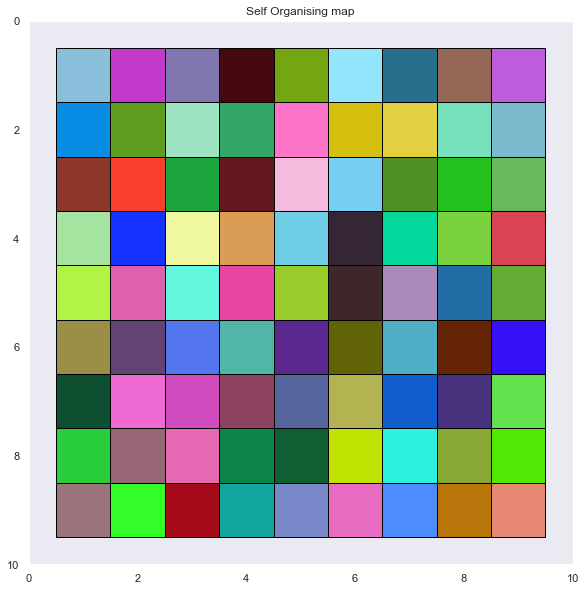

  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 0, Loss: 1.2367, lr: 0.8000, R: 4.0000
Iteration: 50, Loss: 0.0853, lr: 0.6000, R: 3.0000
Iteration: 100, Loss: 0.0467, lr: 0.4000, R: 2.0000
Iteration: 150, Loss: 0.0196, lr: 0.2000, R: 1.0000
Iteration: 199, Loss: 0.0006, lr: 0.0040, R: 0.0200


In [61]:
som_net_congress = SOM(map_size=(9,9,X_congress.shape[1]), lr=0.8)
scores_congress = som_net_congress.train(X_congress, y_congress, T=200, viz=False)

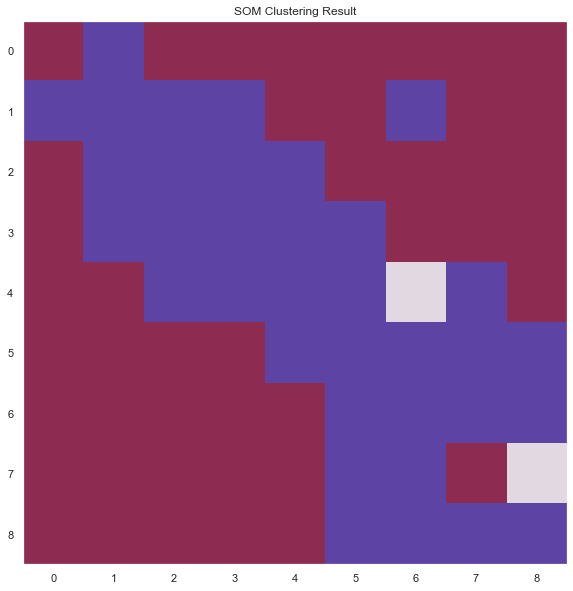

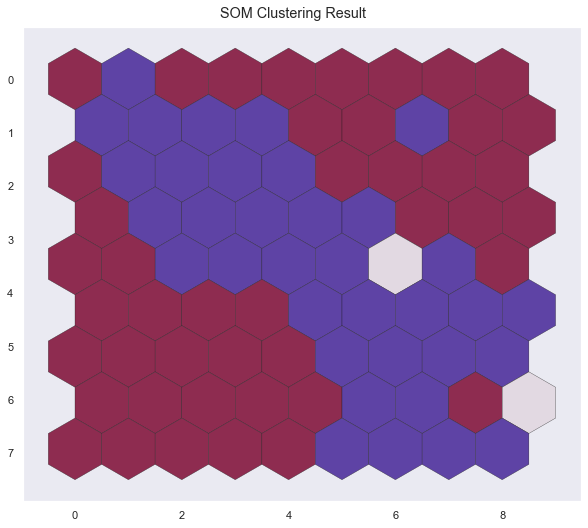

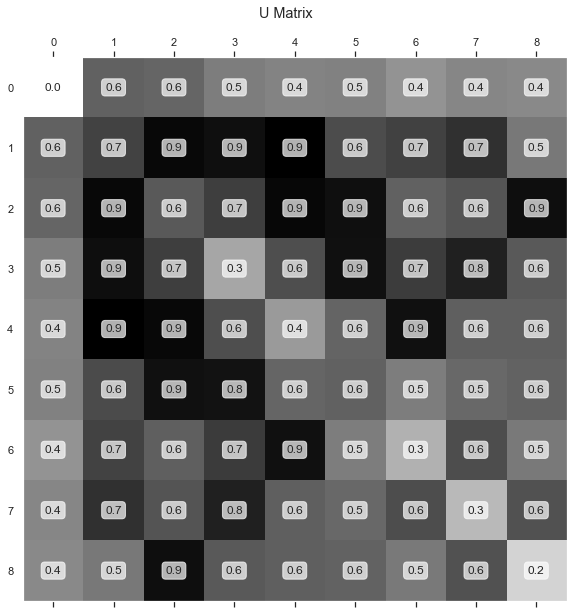

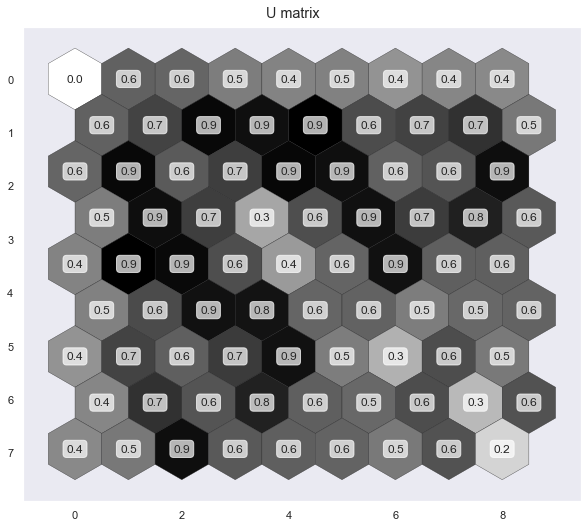

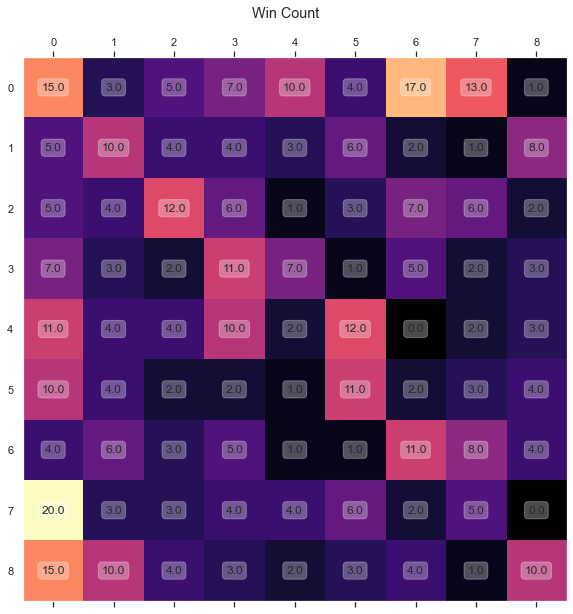

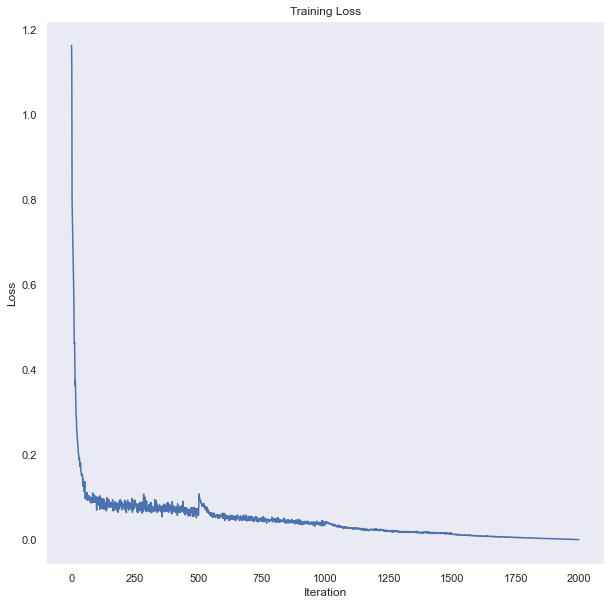

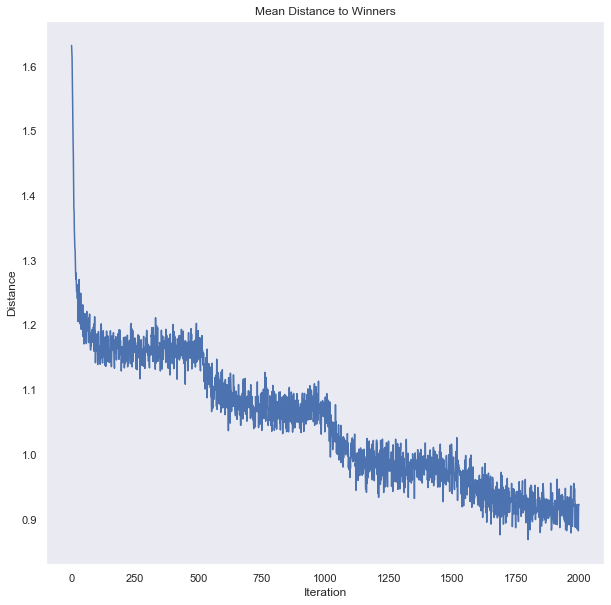

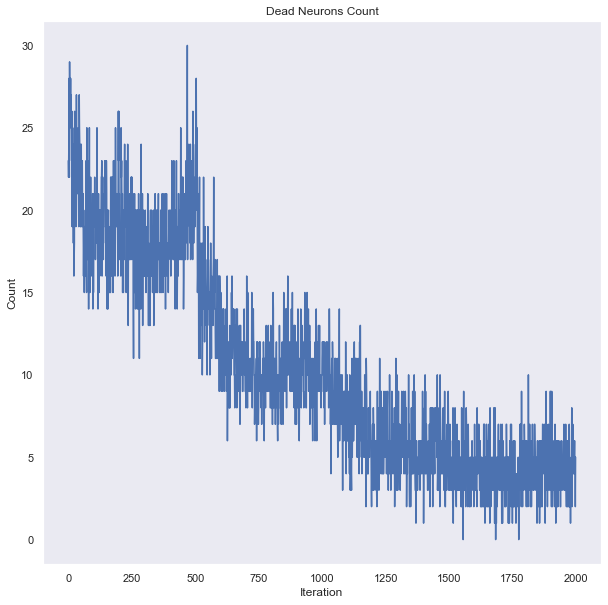

In [60]:
scores = som_net_congress.visualize(X_congress, y_congress, classes=2, cmap='twilight')
som_net_congress.visualize_hex(X_congress, y_congress, classes=2, cmap='twilight')
som_net_congress.plot_U_matrix(R=1)
som_net_congress.plot_U_matrix_hex(R=1)
som_net_congress.plot_win_count()
som_net_congress.plot_loss()
som_net_congress.plot_mean_distance_to_winners()
som_net_congress.plot_dead_neurons_count()